Scoring Plays:

    Determine if the team scored before and after the timeout.
    Include the type of shot (e.g., dunk, 2pt jump shot, 3pt jump shot, free throw).
    Check if the shot was assisted.

Turnovers:

    Identify turnovers before and after the timeout (e.g., steals, blocks, general turnovers).

Rebounds:

    Consider offensive and defensive rebounds before and after the timeout.

Fouls:

    Track fouls committed by the team before and after the timeout.

Overall Score Change:

    Calculate the change in score for the team that called the timeout.

Plus minus:
    the difference between the play before and after a timeout. If the play prior/post the timeout is a non time out team point, that's 2 points lost, and vice versa for the timeout team making a point after the timeout (not before the timeout).


Raw API response for 2024-06-10: {'resource': 'scoreboardV2', 'parameters': {'GameDate': '2024-06-10', 'LeagueID': '00', 'DayOffset': '0'}, 'resultSets': [{'name': 'GameHeader', 'headers': ['GAME_DATE_EST', 'GAME_SEQUENCE', 'GAME_ID', 'GAME_STATUS_ID', 'GAME_STATUS_TEXT', 'GAMECODE', 'HOME_TEAM_ID', 'VISITOR_TEAM_ID', 'SEASON', 'LIVE_PERIOD', 'LIVE_PC_TIME', 'NATL_TV_BROADCASTER_ABBREVIATION', 'HOME_TV_BROADCASTER_ABBREVIATION', 'AWAY_TV_BROADCASTER_ABBREVIATION', 'LIVE_PERIOD_TIME_BCAST', 'ARENA_NAME', 'WH_STATUS', 'WNBA_COMMISSIONER_FLAG'], 'rowSet': []}, {'name': 'LineScore', 'headers': ['GAME_DATE_EST', 'GAME_SEQUENCE', 'GAME_ID', 'TEAM_ID', 'TEAM_ABBREVIATION', 'TEAM_CITY_NAME', 'TEAM_NAME', 'TEAM_WINS_LOSSES', 'PTS_QTR1', 'PTS_QTR2', 'PTS_QTR3', 'PTS_QTR4', 'PTS_OT1', 'PTS_OT2', 'PTS_OT3', 'PTS_OT4', 'PTS_OT5', 'PTS_OT6', 'PTS_OT7', 'PTS_OT8', 'PTS_OT9', 'PTS_OT10', 'PTS', 'FG_PCT', 'FT_PCT', 'FG3_PCT', 'AST', 'REB', 'TOV'], 'rowSet': []}, {'name': 'SeriesStandings', 'headers': [

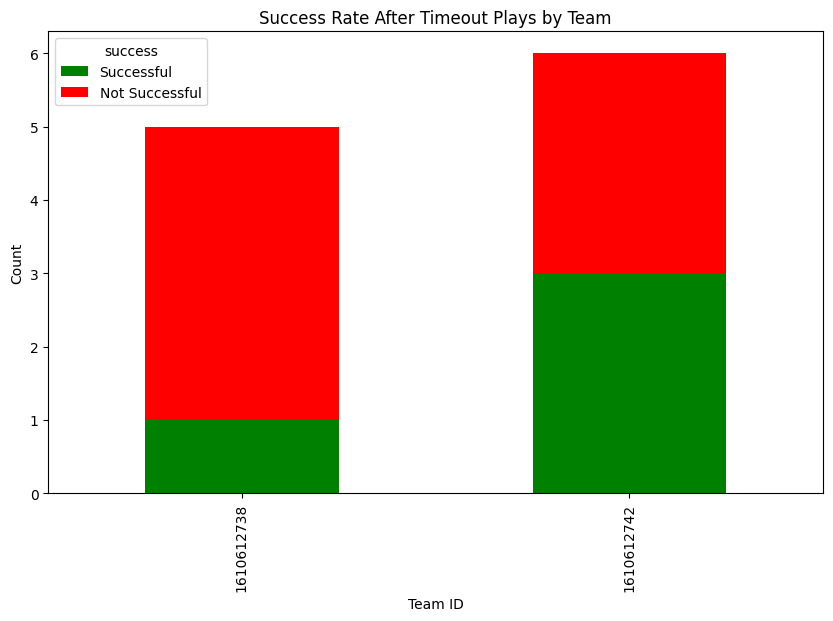

success     Success Rate
team_id                 
1610612738           0.2
1610612742           0.5


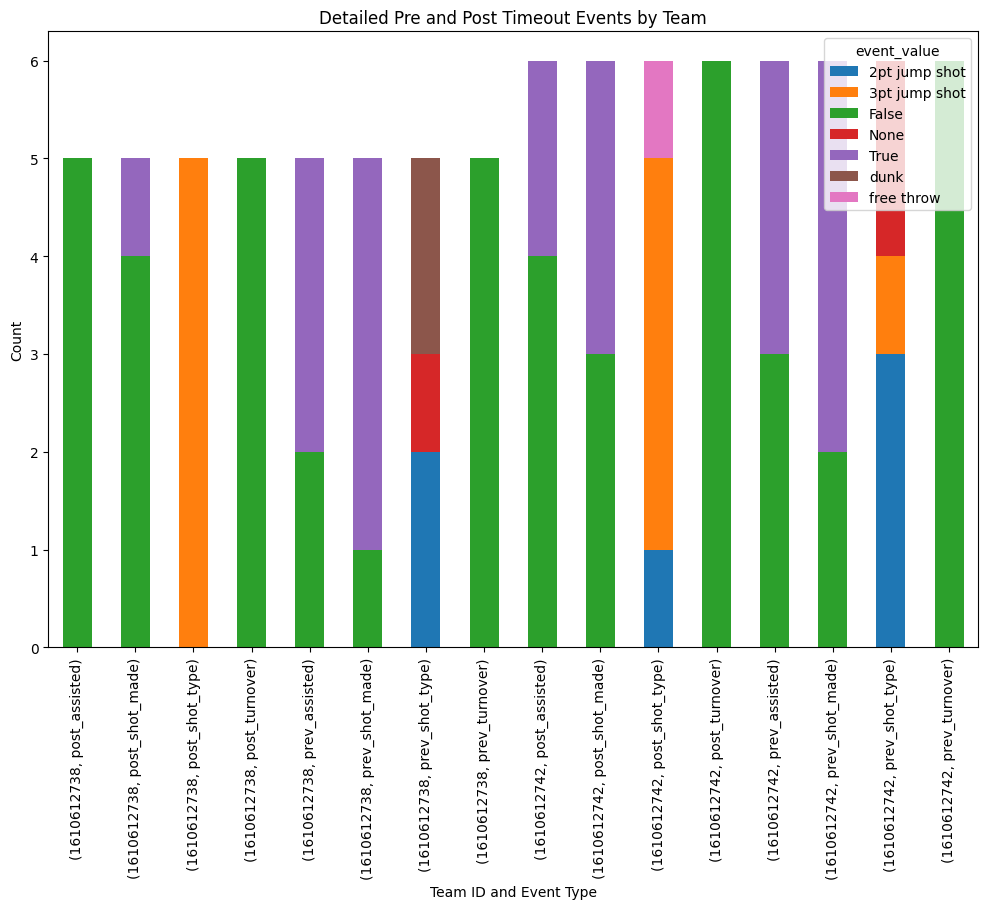

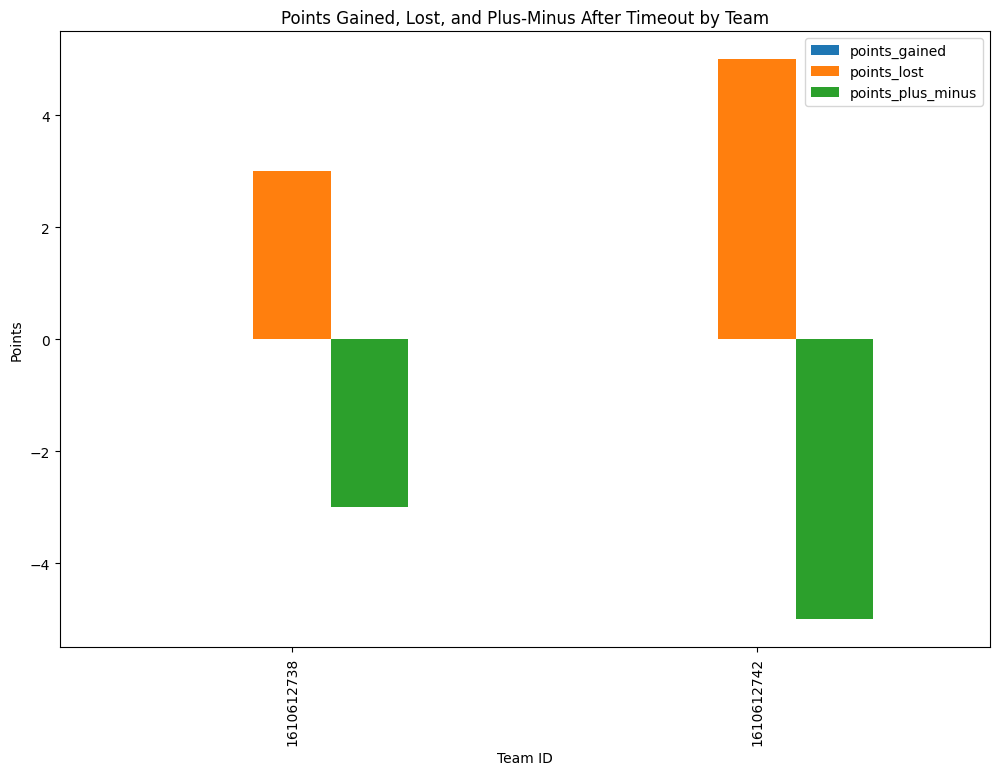

           points_gained points_lost points_plus_minus
team_id                                               
1610612738             0           3                -3
1610612742             0           5                -5


In [3]:
import pandas as pd
from nba_api.stats.endpoints import playbyplayv2, scoreboardv2
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

def get_most_recent_game():
    today = datetime.now()
    for i in range(7):
        game_date = (today - timedelta(days=i)).strftime('%Y-%m-%d')
        try:
            scoreboard = scoreboardv2.ScoreboardV2(game_date=game_date)
            games_data = scoreboard.get_dict()
            
            # Debug print the raw response
            print(f"Raw API response for {game_date}: {games_data}")
            
            # Check if the 'GameHeader' resultSet has data
            if games_data['resultSets'][0]['rowSet']:
                games = pd.DataFrame(games_data['resultSets'][0]['rowSet'], columns=games_data['resultSets'][0]['headers'])
                games = games[['GAME_DATE_EST', 'GAME_ID', 'HOME_TEAM_ID', 'VISITOR_TEAM_ID', 'SEASON']]  # Only keep necessary columns
                return games.iloc[0]  # Return the most recent game found
        except Exception as e:
            print(f"Error retrieving games on date {game_date}: {e}")
    return pd.Series()

def get_play_by_play(game_id):
    try:
        pbp = playbyplayv2.PlayByPlayV2(game_id=game_id)
        pbp_df = pbp.get_data_frames()[0]
        return pbp_df
    except Exception as e:
        print(f"Error retrieving play-by-play data for game ID {game_id}: {e}")
        return None

def extract_shot_info(play_desc):
    if play_desc is None:
        return None, False, False

    shot_type = None
    shot_made = False
    assisted = 'assist' in play_desc.lower() or 'AST' in play_desc

    if 'dunk' in play_desc.lower():
        shot_type = 'dunk'
        shot_made = 'MISS' not in play_desc.upper()
    elif '3pt' in play_desc.lower():
        shot_type = '3pt jump shot'
        shot_made = 'MISS' not in play_desc.upper()
    elif 'jump shot' in play_desc.lower() or 'layup' in play_desc.lower():
        shot_type = '2pt jump shot'
        shot_made = 'MISS' not in play_desc.upper()
    elif 'free throw' in play_desc.lower():
        shot_type = 'free throw'
        shot_made = 'MISS' not in play_desc.upper()

    return shot_type, shot_made, assisted

def extract_turnover_info(play_desc):
    if play_desc is None:
        return False
    return 'turnover' in play_desc.lower() or 'steal' in play_desc.lower() or 'block' in play_desc.lower()

def calculate_points_difference(prev_score, post_score, team_id, home_team_id):
    if prev_score is None or post_score is None:
        return None, None, None
    
    prev_points_home, prev_points_visitor = map(int, prev_score.split('-'))
    post_points_home, post_points_visitor = map(int, post_score.split('-'))
    
    if team_id == home_team_id:
        points_gained = post_points_home - prev_points_home
        points_lost = post_points_visitor - prev_points_visitor
    else:
        points_gained = post_points_visitor - prev_points_visitor
        points_lost = post_points_home - prev_points_home
    
    points_plus_minus = points_gained - points_lost
    return points_gained, points_lost, points_plus_minus

def find_next_relevant_play(pbp_df, start_index):
    next_play_index = start_index + 1
    while next_play_index < len(pbp_df):
        next_play = pbp_df.iloc[next_play_index]
        next_play_desc = next_play['HOMEDESCRIPTION'] or next_play['VISITORDESCRIPTION']
        
        if next_play['EVENTMSGTYPE'] in [1, 2, 3, 4, 5]:  # Shot made, shot missed, free throw, rebound, turnover
            return next_play, next_play_desc
        next_play_index += 1
    return None, None

def find_next_scoring_play_after_turnover(pbp_df, start_index, team_id, home_team_id, visitor_team_id):
    next_play_index = start_index + 1
    while next_play_index < len(pbp_df):
        next_play = pbp_df.iloc[next_play_index]
        next_play_desc = next_play['HOMEDESCRIPTION'] or next_play['VISITORDESCRIPTION']
        scoring_team_id = home_team_id if next_play['HOMEDESCRIPTION'] else visitor_team_id

        if next_play['EVENTMSGTYPE'] == 1:  # Shot made
            if scoring_team_id != team_id:
                return next_play, next_play_desc
        next_play_index += 1
    return None, None

def analyze_after_timeout_plays(pbp_df, home_team_id, visitor_team_id):
    try:
        timeouts = pbp_df[pbp_df['EVENTMSGTYPE'] == 9]  # 9 represents timeouts
        ato_analysis = pd.DataFrame(columns=[
            'timeout_index', 'team_id', 'prev_shot_type', 'prev_shot_made', 'prev_assisted', 'previous_score',
            'prev_turnover', 'post_shot_type', 'post_shot_made', 'post_assisted', 'post_score', 'post_turnover',
            'points_gained', 'points_lost', 'points_plus_minus'
        ])

        for i, row in timeouts.iterrows():
            timeout_index = row.name
            if timeout_index > 0 and timeout_index < len(pbp_df) - 1:
                previous_play = pbp_df.iloc[timeout_index - 1]
                previous_score = previous_play['SCORE']
                previous_play_desc = previous_play['HOMEDESCRIPTION'] or previous_play['VISITORDESCRIPTION']
                
                prev_shot_type, prev_shot_made, prev_assisted = extract_shot_info(previous_play_desc)
                prev_turnover = extract_turnover_info(previous_play_desc)

                next_play, next_play_desc = find_next_relevant_play(pbp_df, timeout_index)
                
                if next_play is not None:
                    next_score = next_play['SCORE']
                    post_shot_type, post_shot_made, post_assisted = extract_shot_info(next_play_desc)
                    post_turnover = extract_turnover_info(next_play_desc)
                else:
                    next_score = None
                    post_shot_type = post_shot_made = post_assisted = post_turnover = None

                # Determine the team calling the timeout
                team_id = home_team_id if row['HOMEDESCRIPTION'] else visitor_team_id

                # Calculate points gained, lost, and plus-minus
                points_gained, points_lost, points_plus_minus = calculate_points_difference(previous_score, next_score, team_id, home_team_id)

                # If turnover, find the next scoring play
                if prev_turnover:
                    next_scoring_play, next_scoring_play_desc = find_next_scoring_play_after_turnover(pbp_df, timeout_index, team_id, home_team_id, visitor_team_id)
                    if next_scoring_play is not None:
                        next_score = next_scoring_play['SCORE']
                        points_gained, points_lost, points_plus_minus = calculate_points_difference(previous_score, next_score, team_id, home_team_id)

                ato_analysis = pd.concat([ato_analysis, pd.DataFrame({
                    'timeout_index': [timeout_index],
                    'team_id': [team_id],
                    'prev_shot_type': [prev_shot_type],
                    'prev_shot_made': [prev_shot_made],
                    'prev_assisted': [prev_assisted],
                    'previous_score': [previous_score],
                    'prev_turnover': [prev_turnover],
                    'post_shot_type': [post_shot_type],
                    'post_shot_made': [post_shot_made],
                    'post_assisted': [post_assisted],
                    'post_score': [next_score],
                    'post_turnover': [post_turnover],
                    'points_gained': [points_gained],
                    'points_lost': [points_lost],
                    'points_plus_minus': [points_plus_minus]
                })], ignore_index=True)
        
        return ato_analysis
    except Exception as e:
        print(f"Error analyzing after timeout plays: {e}")
        return pd.DataFrame()

def visualize_ato_analysis(ato_analysis):
    try:
        # First visualization: success rate by team
        ato_analysis['success'] = ato_analysis.apply(lambda row: 'Successful' if row['post_shot_made'] and not row['post_turnover'] else 'Not Successful', axis=1)
        team_success = ato_analysis.groupby(['team_id', 'success']).size().unstack(fill_value=0)

        team_success['Total'] = team_success.sum(axis=1)
        team_success['Success Rate'] = team_success['Successful'] / team_success['Total']

        team_success.plot(kind='bar', y=['Successful', 'Not Successful'], stacked=True, figsize=(10, 6), color=['green', 'red'])
        plt.xlabel('Team ID')
        plt.ylabel('Count')
        plt.title('Success Rate After Timeout Plays by Team')
        plt.show()

        team_success_rate = team_success[['Success Rate']]
        print(team_success_rate)
        
        # Second visualization: detailed pre and post timeout events
        pre_post_events = ato_analysis.melt(
            id_vars=['team_id', 'timeout_index'],
            value_vars=['prev_shot_type', 'prev_shot_made', 'prev_assisted', 'prev_turnover', 'post_shot_type', 'post_shot_made', 'post_assisted', 'post_turnover'],
            var_name='event_type',
            value_name='event_value'
        )
        
        pre_post_events['event_value'] = pre_post_events['event_value'].astype(str)

        pre_post_events_pivot = pre_post_events.pivot_table(
            index=['team_id', 'event_type'],
            columns='event_value',
            aggfunc='size',
            fill_value=0
        )

        pre_post_events_pivot.plot(kind='bar', stacked=True, figsize=(12, 8))
        plt.xlabel('Team ID and Event Type')
        plt.ylabel('Count')
        plt.title('Detailed Pre and Post Timeout Events by Team')
        plt.show()

        # Third visualization: points gained, lost, and plus-minus by team
        points_summary = ato_analysis.groupby('team_id')[['points_gained', 'points_lost', 'points_plus_minus']].sum()
        
        points_summary.plot(kind='bar', stacked=False, figsize=(12, 8))
        plt.xlabel('Team ID')
        plt.ylabel('Points')
        plt.title('Points Gained, Lost, and Plus-Minus After Timeout by Team')
        plt.show()

        print(points_summary)
        
    except Exception as e:
        print(f"Error visualizing ATO analysis: {e}")

def main():
    recent_game = get_most_recent_game()
    
    if not recent_game.empty:
        print(f"Most Recent Game Details:")
        print(recent_game)
        
        game_id = recent_game['GAME_ID']
        home_team_id = recent_game['HOME_TEAM_ID']
        visitor_team_id = recent_game['VISITOR_TEAM_ID']
        
        pbp_df = get_play_by_play(game_id)
        if pbp_df is not None:
            ato_analysis = analyze_after_timeout_plays(pbp_df, home_team_id, visitor_team_id)
            if not ato_analysis.empty:
                print(ato_analysis.head())  # Print only the first few rows for brevity
                visualize_ato_analysis(ato_analysis)
            else:
                print("No after timeout plays found in the game.")
        else:
            print("No play-by-play data found.")
    else:
        print(f"No recent games found.")

if __name__ == "__main__":
    main()
